# Statistical Forecasting on Synthetic Data

In [34]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

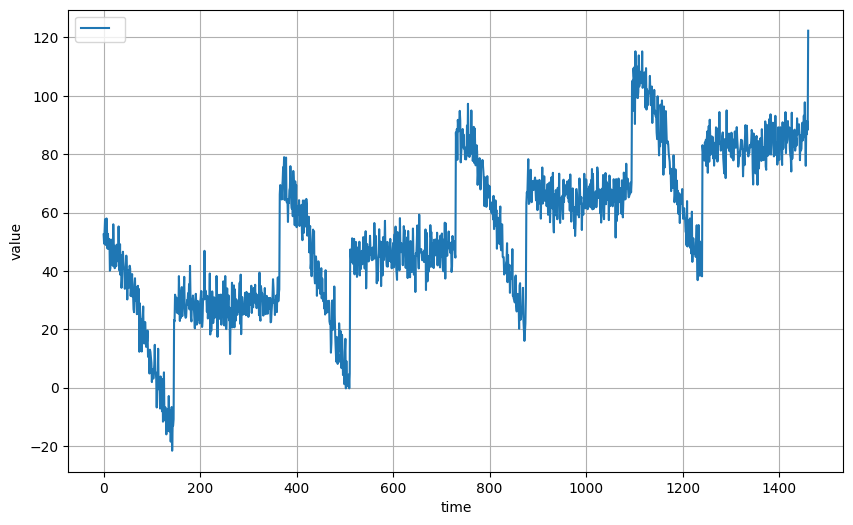

In [35]:
from SequenceModelsTimeSeries.utils import trend, seasonality, noise, plot_series

# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [36]:
# Split the data into training and validation sets
split_time = 1000

time_train = time[:split_time]
y_train = series[:split_time]

time_valid = time[split_time:]
y_valid = series[split_time:]

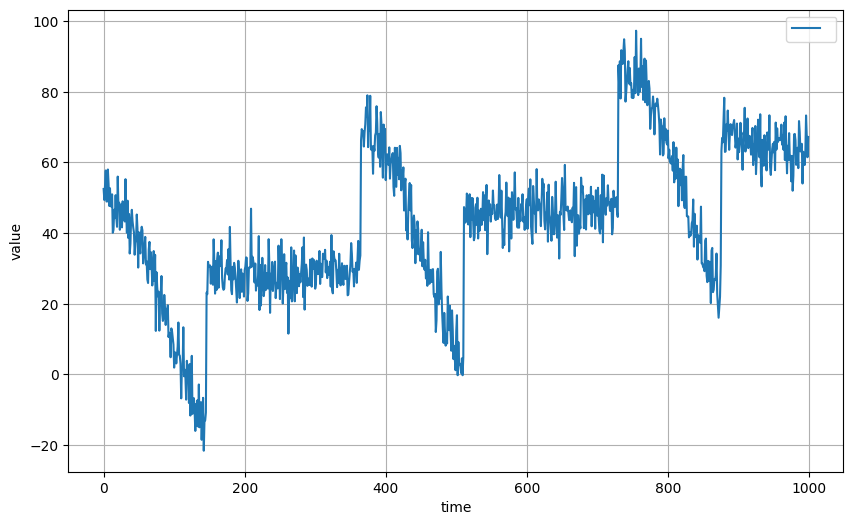

In [37]:
plot_series(time_train, y_train)

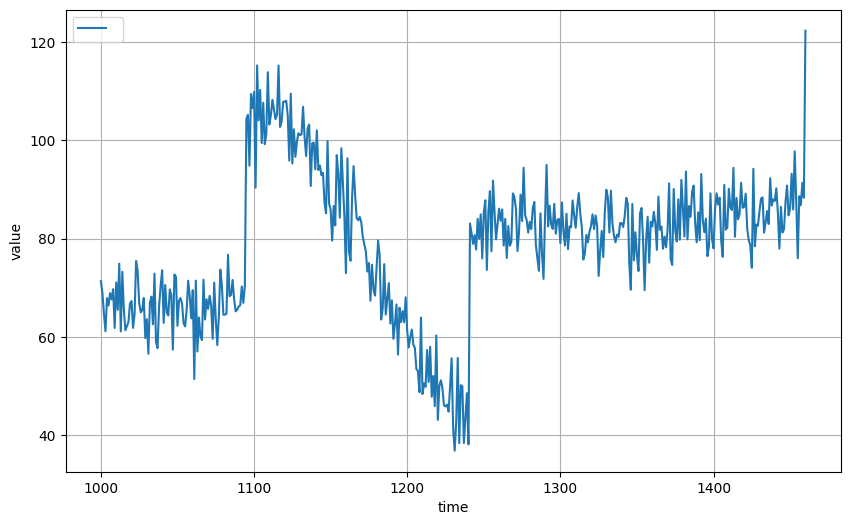

In [38]:
plot_series(time_valid, y_valid)

## Naive Forecast
As a baseline, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

In general naive forecasting means copying the latest known value (forecasting that tommorow will be the same as today)

461 461
ground truth at time step 459: 88.3238296508789
prediction at time step 460: 88.3238296508789


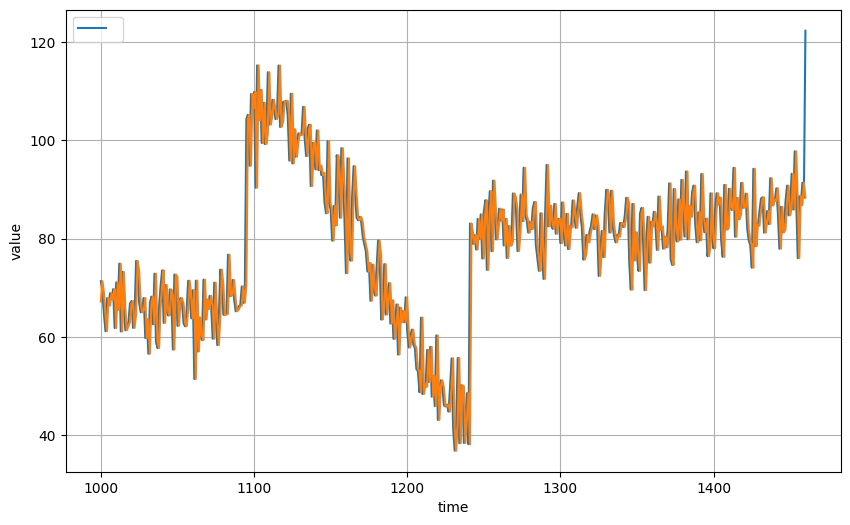

In [39]:
naive_forecast = series[split_time-1:-1]

# Define time step
time_step = 459

# Print values
print(len(naive_forecast), len(y_valid))
print(f'ground truth at time step {time_step}: {y_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

plot_series(time_valid, (y_valid, naive_forecast))

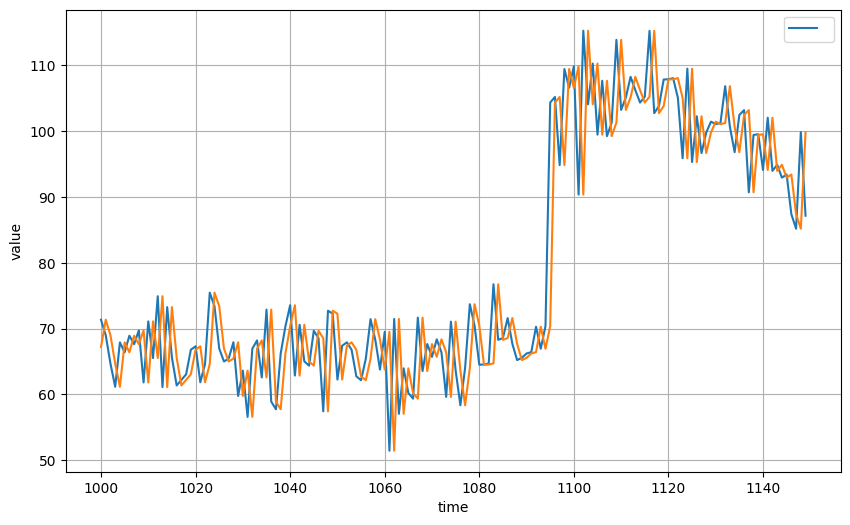

In [40]:
# Zooming in
plot_series(time_valid, (y_valid, naive_forecast), start=0, end=150)

## Computing Metrics

In [41]:
print(tf.keras.metrics.mean_squared_error(y_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(y_valid, naive_forecast).numpy())

61.827526
5.9379086


**MAE, MSE, MSE** are among the most common metrics, you can use for evaluate your forecasts. As always, depend on the task.
For example, if yor project suffer from quadratically more from large errors than from small ones, then the MSE is preferable, as it strongly penalizes large errors.


## Moving Average
One technique you can use is to do a moving average. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

The function below does the moving average for the entire series. It takes a window_size argument to indicate the number of time steps to consider when computing the mean.

In [51]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

106.67457
7.142419


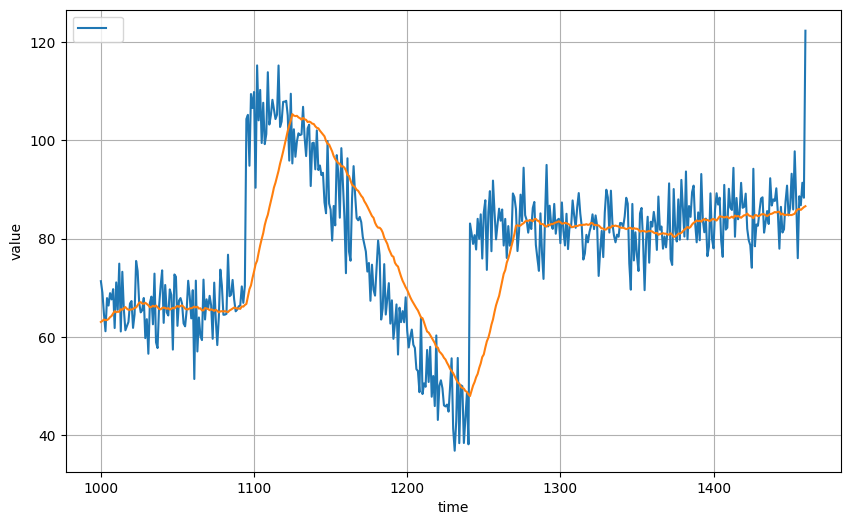

In [52]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Compute the metrics
print(tf.keras.metrics.mean_squared_error(y_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(y_valid, moving_avg).numpy())

# Plot the results
plot_series(time_valid, (y_valid, moving_avg))

# Differencing
Since the seasonality period is 365 days, you will subtract the value at time t – 365 from the value at time t. That is done with the code below.

In addition, you will need to align the result with the time array. Since you can only do time differencing for t >= 365, you will need to truncate the first 365 time steps of the time array.

You can plot the result to visualize the values.

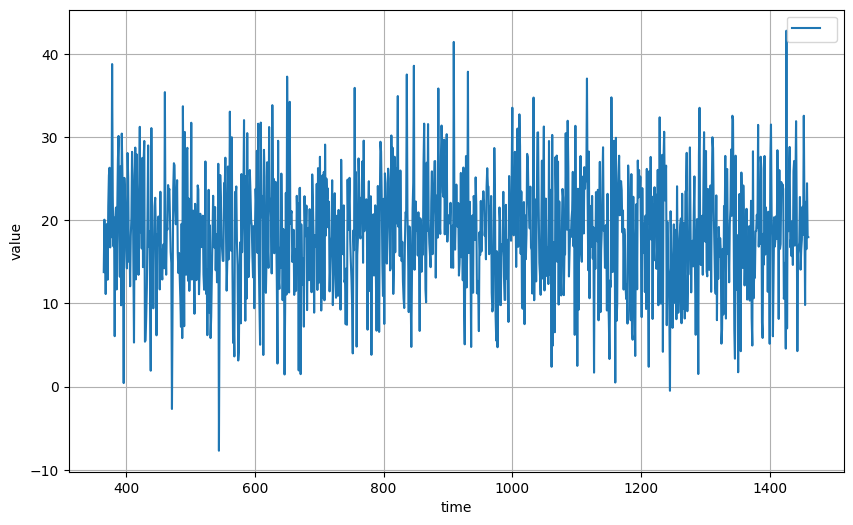

In [53]:
# Subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)

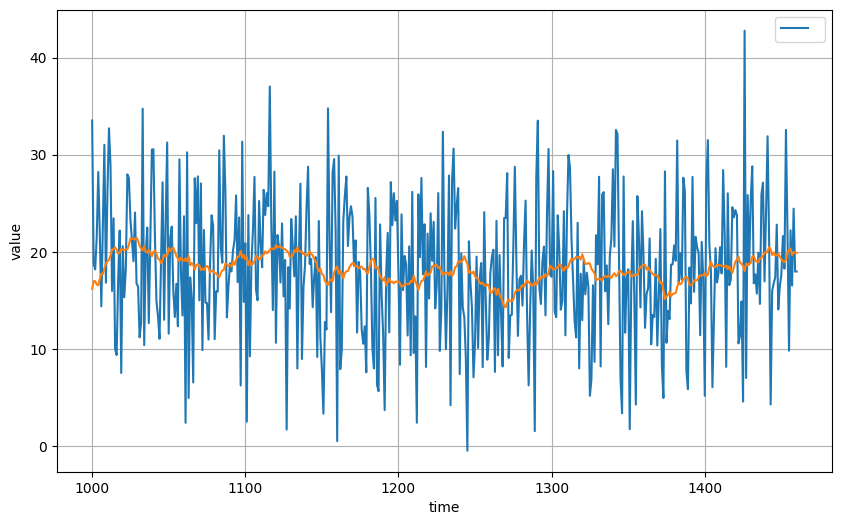

In [54]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg))

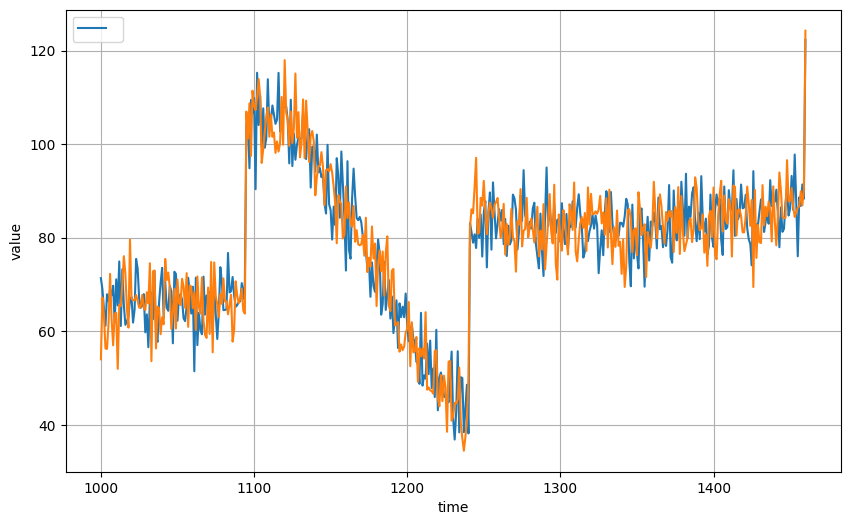

In [55]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (y_valid, diff_moving_avg_plus_past))